## Libraries

In [1]:
import os
import h5py
import cv2

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Loading

In [2]:
def load(dbname, dataset):
    '''
    dbname is the path to the database hdf file, dataset is the dataset name.
    returns a pandas dataframe and a dictionary with meta data for the dataset.
    '''
    attrs = None
    with h5py.File(dbname) as f:
        if dataset not in f.keys():
            raise ValueError('Can\'t find dataset. Available keys are: ' + str(f.keys()))
        try:
            df = pd.DataFrame(dict((k, f[dataset][k][:].ravel()) for k in f[dataset].keys()))
        except ValueError:
            raise RuntimeError('Not all fields have the same length:' +
                str(dict((k, f[dataset][k][:].ravel().shape) for k in f[dataset].keys())))
        if len(f[dataset].attrs.keys())>0:
            attrs = dict((k, f[dataset].attrs[k]) for k in  f[dataset].attrs.keys())
    return df, attrs

In [3]:
os.chdir('/Users/hyunwoogu/Dropbox/2018Autumn/GradThesis/EyeTracking_data/')

In [4]:
Data, attrs = load("etdb_v1.0.hdf5", "Face Discrim.")

## Exploratory Data Analysis

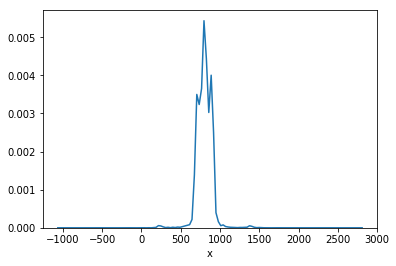

In [5]:
sns.distplot(Data['x'], hist=False)
plt.show()

## Data Processing

In [6]:
Data.columns.values

array(['SUBJECTINDEX', 'category', 'chain', 'condition', 'dataset_nr',
       'end', 'filenumber', 'fix', 'isref', 'phase', 'start', 'trial',
       'x', 'y'], dtype=object)

#### Counts and Duration

In [7]:
Data['counts'] = Data.groupby(['SUBJECTINDEX','trial']).cumcount()
Data.loc[:, 'Duration'] = Data.loc[:,'end'] - Data.loc[:,'start']

#### Right Censoring

In [8]:
Data.loc[(Data.counts==0) & (Data.end > 1450),['start', 'end', 'x', 'y', 'counts']].shape

(115, 5)

#### Face Feature Window

In [9]:
ChopSize = (80,60) ## pieces (x,y)
Data.loc[:, 'CumIndex'] = (Data.loc[:,'x']//ChopSize[0]) * ChopSize[0] + ((1200-Data.loc[:,'y'])//ChopSize[1])

#### Mean Duration by Face Features

In [10]:
def transparent_cmap(cmap, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.Reds)

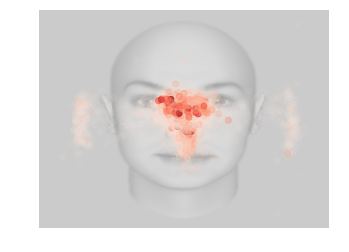

In [46]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(Data.loc[(Data.counts==0),'x'], Data.loc[(Data.counts==0),'y'],\
            c=Data.loc[(Data.counts==0),'Duration'], cmap=mycmap)
plt.show()


#### Optimal Window

In [87]:
def countFixations(startX, startY, winSize=150):
    res = Data.loc[(Data.counts==0) & 
                   (Data.x>=startX) & (Data.x<=startX+winSize) &
                   (Data.y>=startY) & (Data.y<=startY+winSize) ,'start'].shape[0]
    return(res)

In [124]:
def meanDurations(startX, startY, winSize=150):
    res = np.mean(Data.loc[(Data.counts==0) & 
                           (Data.x>=startX) & (Data.x<=startX+winSize) &
                            (Data.y>=startY) & (Data.y<=startY+winSize) ,'Duration'])
    return (res)

In [120]:
## Greedy Search

SegsX = np.arange(0, 1600-150, 20)
SegsY = np.arange(0, 1200-150, 20)

countRes = []
for i in SegsX:
    for j in SegsY:
        countRes.append((i,j,countFixations(i,j)))

np.array(countRes)[np.array(countRes)[:,2],:]

array([ 700,  480, 6615])

In [127]:
meanRes = []
for i in SegsX:
    for j in SegsY:
        meanRes.append((i,j,meanDurations(i,j)))

np.array(meanRes)[np.nanargmax(np.array(meanRes)[:,2]),:]

array([ 0.,  0., nan])

In [138]:
A = np.array(countRes)[np.argsort(-np.array(countRes)[:,2]),:]
A

array([[ 700,  480, 6615],
       [ 720,  480, 6579],
       [ 700,  500, 6573],
       ...,
       [ 560,   80,    0],
       [ 540,  820,    0],
       [1440, 1040,    0]])

In [143]:
A.shape

(3869, 3)

In [139]:
B = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]
B

array([[ 900.,  800.,  346.],
       [ 940.,  800.,  346.],
       [ 920.,  800.,  346.],
       ...,
       [ 560.,   80.,   nan],
       [ 540.,  820.,   nan],
       [1440., 1040.,   nan]])

In [144]:
mycmapR = transparent_cmap(plt.cm.Reds)
mycmapB = transparent_cmap(plt.cm.Blues)

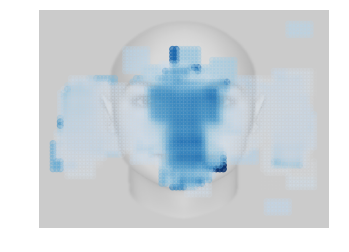

In [154]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(B[:,0]+75, B[:,1]+75, c=B[:,2], cmap=mycmapB)
plt.show()

#### Fixation proportion as a function of time

In [12]:
def FixationProp(t):
    return(sum((Data.loc[:,'start'] <= t) & (Data.loc[:,'end'] >= t)))

In [ ]:
def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'end'] >= t)))

In [86]:
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=390) & (Data.y<=540), 'Duration'].shape # original eye

(1183,)

In [75]:
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=660) & (Data.y<=810) ,'start'].shape # reverse eye

(87,)

In [76]:
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=480) & (Data.y<=630) ,'start'].shape # original concen

(24028,)

In [77]:
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'].shape # reverse concen

(2946,)

In [78]:
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=720) & (Data.y<=870) ,'start'].shape # original mouth

(5891,)

In [79]:
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=330) & (Data.y<=480) ,'start'].shape # reverse mouth

(748,)

In [168]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=410) & (Data.y<=410+150) ,'Duration'].shape

(6324,)

In [169]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=570) & (Data.y<=570+150) ,'Duration'].shape

(3518,)

In [170]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=740) & (Data.y<=740+150) ,'Duration'].shape

(165,)

In [163]:
coord = (520, 390) ## x coord (from left), y coord (from top) 
coord = (720, 720)
(720, 550)

coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
#coord4 = (900, 410)

def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'end'] >= t)))

def FixationProp2(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'end'] >= t)))

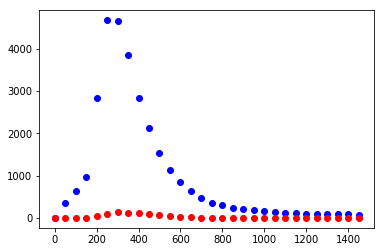

In [164]:
timeSegs = np.arange(0, 1500, 50)
props1 = [FixationProp1(x) for x in timeSegs]
props2 = [FixationProp2(x) for x in timeSegs]

plt.plot(timeSegs, props1, 'bo')
plt.plot(timeSegs, props2, 'ro')

plt.show()

**Maxtrix Method**

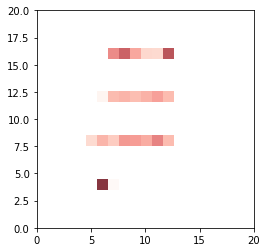

In [179]:
Data_index = Data.loc[(Data.counts==0)]
Data_index = Data_index.groupby(['CumIndex']).mean()
Data_index.index.name = 'CumIndex'
Data_index.reset_index(inplace=True)
Data_index = Data_index.loc[(Data_index.CumIndex >= 0) & (Data_index.CumIndex < 20*20),\
                            ['CumIndex', 'Duration']]
Data_index = Data_index.set_index('CumIndex').reindex(range(0,20*20)).fillna(0).reset_index()
Data_index = Data_index.Duration.values.reshape(20,20)

plt.imshow(Data_index, cmap='Reds', interpolation='nearest')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

In [ ]:
df.groupby(['cluster']).mean()

In [68]:
Order = Data[Data['filenumber']==Num]

## Image Handling

In [10]:
def transparent_cmap(cmap, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.Reds)

#### Gaze map by different faces

pictures used : (21, 5, 1, 17, 29, 13) based on the frequency.

Pic|Freq
-|-
21|    10660
5|     10289
1|     10215
17|    10146
29|     9292
13|     9065

KeyboardInterrupt: 

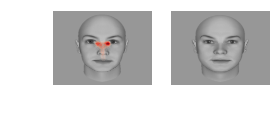

In [13]:
fig = plt.figure()

for i, Num in enumerate((21, 5, 1, 17, 29, 13)):
    
    FileNum = Data[Data['filenumber']==Num]
    adr = '21/' + str(Num) + '.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "23" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(FileNum['x'], FileNum['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

#### Salience map by fixation area

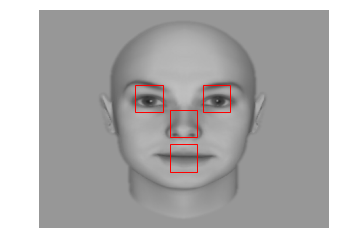

In [151]:
coord1 = (530, 410) ## x coord (from left), y coord (from top) 
coord2 = (720, 550)
coord3 = (720, 740)
coord4 = (900, 410)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,150,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,150,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,150,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
rect4 = patches.Rectangle(coord4,150,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect4)

plt.show()

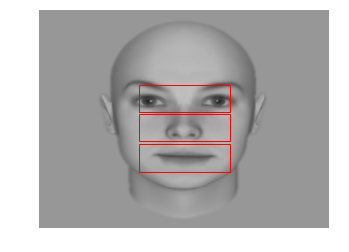

In [158]:
coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
#coord4 = (900, 410)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,500,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,500,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,500,150,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
#rect4 = patches.Rectangle(coord4,150,150,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect4)

plt.show()

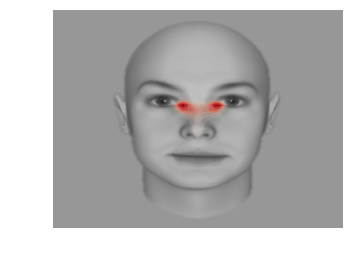

In [14]:
fig = plt.figure()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax = sns.kdeplot(FileNum['x'], FileNum['y'], shade = True, cmap = mycmap)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)

plt.show()

#### Salience map by fixation order

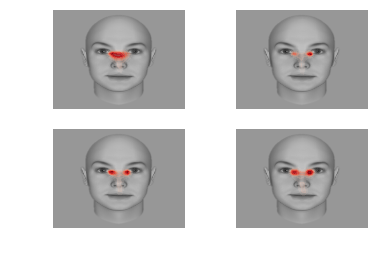

In [125]:
fig = plt.figure()

for i, Order in enumerate((1, 3, 5, 7)):
    
    GazeOrder = Data[Data['counts']==Order]
    adr = '21/1.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "22" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(GazeOrder['x'], GazeOrder['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

## Survival Analysis

## Prediction

## Eye-contact Simulation